# Training Deep Neural Networks

# 3.1 Introduction

Some changes to the basic backpropagation algorithm and clever methods for initialization, such as pretraining, have also helped. It has also become easier in recent years to perform the intensive experimentation required for making algorithmic adjustments due to the reduced testing cycle times (caused by improved computational hardware). Therefore, increased data, computational power, and reduced experimentation time (for algorithmic tweaking) went hand-in-hand. These so-called “tweaks” are, nevertheless, very important; this chapter and the next will discuss most of these important algorithmic advancements.


The backpropagation algorithm is rather unstable to minor changes in the algorithmic setting, such as the initialization point used by the approach. Very significant with very deep networks!

As a Multivariable optimization problem, stability can be a challenge because one must perform the steps along each direction in the "right" proportion. This turns out to be particularly hard in the neural network domain, and the effect of a gradient-descent step might be somewhat unpredictable.

The complex optimization surfaces presented by neural network optimization are particularly treacherous and the problem is exacerbated with poorly chosen settings (such as the initialization point or the normalization of the input features). As a result, the (easily computable) steepest-descent direction is often not the best direction to use for retaining the ability to use large steps. Small step sizes lead to slow progress, whereas the optimization surface might change in unpredictable ways with the use of large step sizes. 

Many of these problems can be avoided by carefully tailoring the gradient-descent steps to be more robust to the nature of the optimization surface.

In [57]:
import numpy as np

choices = ['black','white']

a = {'black': 2, 'white': 1}
b = {'black': 6, 'white': 4}

for i in range(10):
    rand = np.random.choice(choices)
    other_choice = np.setdiff1d(np.array(choices), np.array([rand]))[0]
    print(rand)

    if a[rand] > 0:
        #print("YESS:", a)
        a[rand] = a[rand] - 1
        b[rand] = b[rand] + 1
        
#     if a[other_choice] 
    
    if a[rand] == 0:
        #print("ELSE:", a)
        a[other_choice] = a[other_choice] - 1
        b[other_choice] = b[other_choice] + 1
        
    print(a)
        

# print(b['black'], b['white'], b['black']/(b['black'] + b['white']))
print(a)
print(b)

print(a['white']+b['white'], a['black'] + b['black'])

black
{'black': 1, 'white': 1}
white
{'black': 0, 'white': 0}
black
{'black': 0, 'white': -1}
white
{'black': 0, 'white': -1}
black
{'black': 0, 'white': -2}
black
{'black': 0, 'white': -3}
black
{'black': 0, 'white': -4}
white
{'black': 0, 'white': -4}
black
{'black': 0, 'white': -5}
white
{'black': 0, 'white': -5}
{'black': 0, 'white': -5}
{'black': 8, 'white': 10}
5 8


In [31]:
rand = 'white'

other_choice = np.setdiff1d(np.array(choices), np.array([rand]))[0]

'black'

In [18]:
a

{'black': 2, 'white': 3}

# 3.2 Backpropagation: The Gory Details

## 3.2.1 Backpropagation with the Computational Graph Abstraction

A neural network is a computational graph, and each neuron is a unit of computation. A multilayer network evaluates compositions of functions computed at individual nodes. 

Trivial path length 2 example:

If the sigmoid function is applied at each node to the input weight $w$, where a path of length 2 in the neural network in which the function $f(\cdot)$ follows $g(\cdot)$ can be considered a composition function $f(g(\cdot))$. The computed function is

$$f(g(w)) = \frac{1}{1 + \exp \left[-\frac{1}{1+\exp[-w]}\right]} \qquad (3.1)$$

This derivative is awkward with respect to $w$ and each $g_k$ is a function computed in layer $m$ where they feed into the $(m+1)$ layer in terms of layer $m$ inputs.

Thus the composition function by the $(m+1)$ layer is $f(g_1(\cdot), \dots, g_k(\cdot))$.

Recursion is a pain here at a nested function of depth 10 would require a summation with $2^{10}$ terms, so we defer to dynammic programming.

Then the update is the chain rule.

$$\frac{\partial f(g(w))}{\partial w} = \frac{\partial f(g(w))}{\partial g(w)} \cdot \frac{\partial g(w)}{\partial w}$$

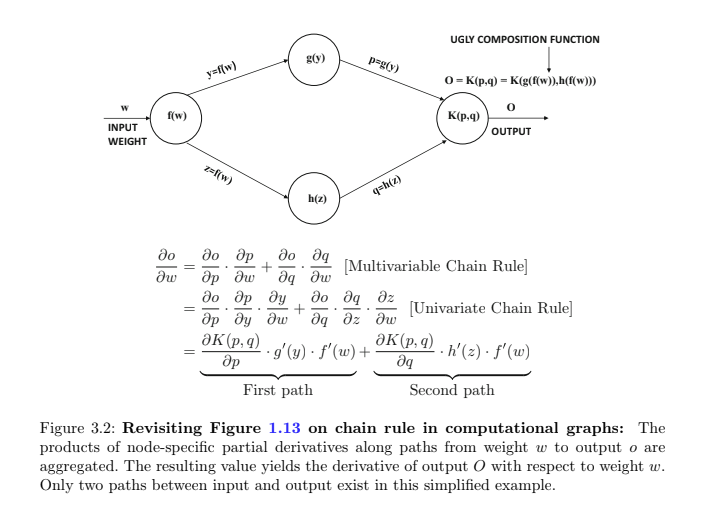

Univariate Chain Rule

$$\frac{\partial o}{\partial w} = \frac{\partial K(p,q)}{\partial p} \cdot g'(y) \cdot f'(w) +
                                  \frac{\partial K(p,q)}{\partial q} \cdot h'(z) \cdot f'(w)$$
                                  
Each summatory term represents a different path, where each is a local gradient since it computes the derivative of a function with respect to its immediate argument rather than a recursively derived argument. A composition of functions is applied on the weight $w$ to yield the final output, and the gradient of the final output is given by the product of the local gradients along that path.

Each local gradient only needs to worry about its respective input and output, which simplifies the problem. 

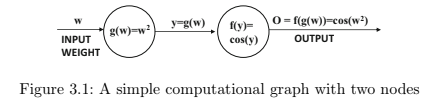

Here $f(y) = cos(y)$ and $g(w) = w^2$. Thus the composition function is $cos(w^2)$. Applying the univariate chain rule we obtain:

$$\frac{\partial f(g(w))}{\partial w} = \frac{\partial f(g(w))}{\partial g(w)} \cdot \frac{\partial g(w)}{\partial w} = -sin(g(w) \cdot 2w$$

However a hidden layer usually gets input from multiple units, therefore multiple paths from a variable $w$ to an output are created.

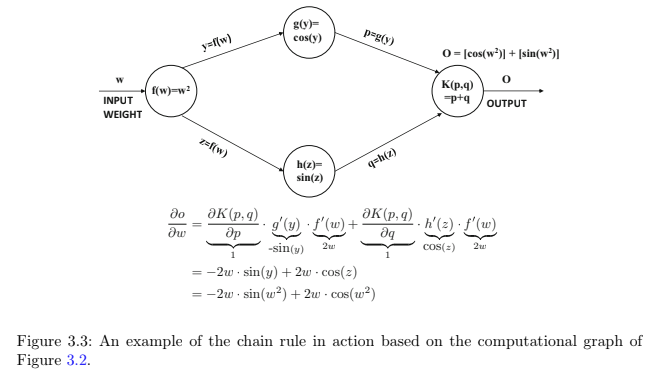

The function $f(g_1(w), \dots, g_k(w))$ gets its inputs from $k$ units computing each $g$. Hence it is multivariate and the multivariate chain rule must be applied. It is defined:

$$\frac{\partial f(g_1(w), \dots, g_k(w))}{\partial w} = 
\sum_{i=1}^{k} \frac{\partial f(g_1(w), \dots, g_k(w))}{\partial g_i(w)} \cdot 
\frac{\partial g_i(w)}{\partial w} \qquad (3.3)$$

Lemma 3.2.1 (Pathwise Aggregation Lemma): The value of $\frac{\partial o}{\partial w}$ where $o$ is the output node variable, a non-null set of paths $\mathcal{P}$ exist from variable w in the graph to output node containing variable o. The lemma then is given by:


$$\frac{\partial o}{\partial w} = \sum_{P \in \mathcal{P}} \prod_{(i,j) \in P} z(i,j)$$

We obtain this equation from (3.3) recursively. It is not used in the actual backpropagation but shows a direct exponential-time algorithm.

Exponential Time Algorithm: Since it is possible to compute the composite derivative as an aggregation of the products of the local derivatives along all paths in the computational graph, we obtain the following:

1. Use graph to compute $y(i)$ of each nodes $i$ in a forward phase.
2. Compute the local partial  derivatives $z(i,j) = \frac{\partial y(j)}{\partial y(i)}$ on each edge in the computational graph
3. Let $\mathcal{P}$ be the set of all paths from an input node with value $w$ to the output. For each path $P \in \mathcal{P}$, compute the product of each local derivative $z(i,j)$ on that path.
4. Add up these values over all paths in $\mathcal{P}$.

Such a computational graph example will have an exponentially increasing number of paths with depth. For example, say a graph has 5 layers each with 2 units. The number of paths between the input and output then is $2^5 = 32$. The $j^{th}$ hidden unit of the $i^{th}$ layer is denoted by $h(i,j)$. 

Each hidden unit is defined as the product of its inputs:

$$h(i,j) = h(i-1,1) \cdot h(i-1,2) \quad \forall j \in \{1,2\} \qquad (3.6)$$

Using the exponential time algorithm, the derivative of each $h(i,j)$ with respect to each of its two inputs are the values of the complementary inputs:

$$\frac{\partial h(i,j)}{\partial h(i-1,1)} = h(i-1,2), \quad \frac{\partial h(i,j)}{\partial h(i-1,2)} = h(i-1,1)$$

Using Lemma 3.2.1, one can compute the local derivatives and multiply them,

$$\frac{\partial o}{\partial w} = \sum_{j_1, \dots, j_5 \in \{1,2\}} \prod h(1,j_1) \cdots h(5,j_5)$$

$$= \sum_{\text{All 32 paths}} w^{31} = 32w^{31}$$

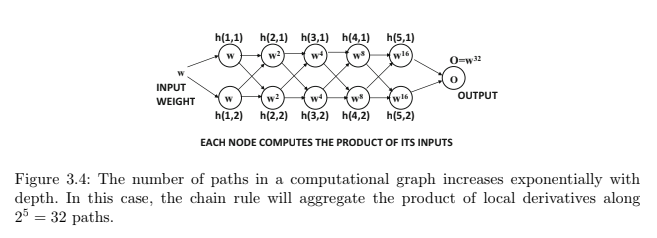

Note that we repeatedly differentiate the same function computed in a node for aggregation.

## 3.2.2 Dynamic Programming to the Rescue

Consider a directed **acyclic** graph where $z(i,j)$ (the local partial derivative of variable in node $j$ with respect to variable in node $i$) is associated with edge (i,j). 

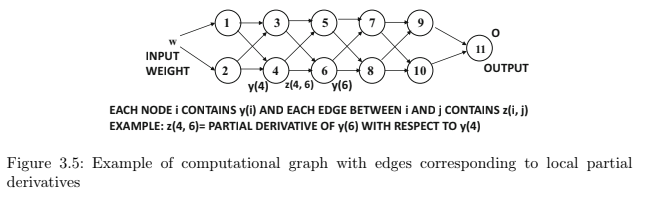

We want the product of $z(i,j)$ over each path $p \in \mathcal{P}$ from source node $w$ to output $o$ and add them:

$$S(w,o) = \sum_{P \in \mathcal{P}} \prod_{(i,j) \in P} z(i,j)$$

Let $A(i)$ be the set of nodes at the end points of outgoing edges from node $i$. To compute the aggregated value $S(i,o)$ for each intermediate node $i$ between $w$ and $o$, we can use the dynamic programming update:

$$S(i,o) \impliedby \sum_{j \in A(i)} S(j,o)z(i,j)$$


This computation can be performed backwards starting from the nodes directly incident on $o$, since $S(o, o)$ is already known to be 1.

In the case of neural networks, one can easily compute $\frac{\partial L}{\partial o}$ in terms of the known value of $o$ (by running the input through the network). This derivative is propagated backwards using the local partial derivatives $z(i, j)$, depending on which variables in the neural network are used as intermediate variables. For example, when the post-activation values inside nodes are treated as nodes of the computational graph, the value of $z(i, j)$ is the product of the weight of edge $(i, j)$ and the local derivative of the activation at node $j$. On the other hand, if we use the pre-activation variables as the
nodes of the computational graph, the value of $z(i, j)$ is product of the local derivative of the activation at node $i$ and the weight of the edge $(i, j)$. We can even create computational graphs containing both pre-activation and post-activation variables to decouple linear operations from activation functions.

## 3.2.3 Backpropagation with Post-Activation Variables

We consider a computational graph in which the nodes contain the post-activation variables in a neural network. These are the same as the hidden variables of different layers. The backpropagation algorithm first uses a forward phase in order to compute the output and the loss. Therefore, the forward phase sets up the initialization for the dynamic programming recurrence, and also the intermediate variables that will be needed in the backwards phase. The backwards phase uses the dynamic programming recurrence based on the multivariable chain rule of differential calculus.

**Forward Phase**: an input vector is used to compute the values of each hidden layers based on the current values of the weights. Computations neturally cascade forward across layers. This phase computes all the necessary intermediate hidden and output variables for a given input which are required for the backpropagation. When the computation is completed the output $o$ is computed and the derivative of the loss function $L$ with respect to this output is also computed. The loss is typically a function of all the outputs in the presence of multiple nodes; therefore, the derivatives with respect to all outputs are computed.

**Backward Phase**: First we compute $\frac{\partial L}{\partial o}$. This is computed for each output in the case of multiple outputs. This sets up the initialization of the gradient computation. These derivatives are then propagated backwards using the multivariable chain rule in equation (3.3).

Consider a path denoted by a sequence of hidden units $h_1, \dots, h_k$ followed by an output $o$. The weight of the connection from hidden unit $h_r$ to $h_{r+1}$ is denoted by $w_{(h_r, h_{r+1)}}$. In most cases an exponential number of paths exist in the network from any node $h_r$ to output node $o$. From Lemma 3.2.1, the partial derivative can be computed by aggregating the products of partial derivatives over all paths from $h_r$ to $o$. When a set $\mathcal{P}$ of paths exist from $h_r$ to $o$, one can write the loss derivative as follows:

$$\frac{\partial L}{\partial w_{(h_{r-1}, h_r)}} = \frac{\partial L}{\partial o} \cdot
\left[\sum_{[h_r, \dots, h_k, o] \in \mathcal{P}} \frac{\partial o}{\partial h_k} 
\prod_{i=r}^{k-1} \frac{\partial h_{i+1}}{\partial h_i}\right] \frac{\partial h_r}{\partial w_{(h_{r-1}, h_r)}} \qquad (3.9)$$

where backpropagation computes $\Delta (h_r, o) = \frac{\partial L}{\partial h_r}$.

The partial derivative on the right-hand side is useful in converting a recursively
computed partial derivative with respect to layer activations into a partial derivative with
respect to the weights. The path aggregated term, or everything but the right hand most partial is propagated in the backwards direction with dynamic programming updates. 

Applying the multivariable chain rule provides the recursion for $\Delta (h_r, o)$.

$$\Delta (h_r, o) = \frac{\partial L}{\partial h_r} = \sum_{h:h_r \implies h} 
\frac{\partial L}{\partial h} \frac{\partial h}{\partial h_r} = \sum_{h:h_r \implies h} 
\frac{\partial h}{\partial h_r} \Delta (h, o) \qquad (3.10)$$

$\Delta (h, o)$ is already computed while evaluating $\Delta (h_r, o)$ since each $h$ is in a later layer than $h_r$. However we still need $\frac{\partial h}{\partial h_r}$. Consider an edge joing $h_r$ to $h$ which has a weight $w_{(h_r, h)}$ and $a_h$ is the value computed in the hidden unit just before applying the activation function $\Phi(\cdot)$.

Hence $h=\Phi (a_h)$ wwhere $a_h$ is a linear combination of its inputs from ealier layer units incident on $h$. Then by the univariate chain rule:

$$\frac{\partial h}{\partial h_r} = \frac{\partial h}{\partial a_h} \cdot \frac{\partial a_h}{\partial h_r} = \frac{\partial \Phi (a_h)}{\partial a_h} \cdot w_{(h_r, h)} = \Phi '(a_h) \cdot w_{h_r, h)} \qquad (3.11)$$

Hence we obtain:

$$\Delta (h_r, o) = \sum_{h:h_r \implies h} \Phi '(a_h) \cdot w_{h_r, h)} \cdot \Delta (h, o) \qquad (3.12)$$

This recursion is repeated in the backwards direction, starting with the output node. The entire process is linear in the number of edges in the network.

Backpropagation can be summarized in the following steps:
1. Use a forward-pass to compute the values of all hidden units, output $o$, and loss $L$ for a particular input-output pattern $(\overline{X},y)$.
2. Initialize $\Delta(o, o)$ to $\frac{\partial L}{\partial o}$

3. Use the recurrence of Equation 3.12 to compute each $\Delta (h_r, o)$ in the backwards direction. After each such computation, compute the gradients with respect to incident weights as follows:

$$\frac{\partial L}{\partial w_{(h_{r-1}, h_r)}} = \Delta (h_r, o) \cdot h_{r-1} \cdot \Phi '(a_{h_{r}}) \qquad (3.13)$$

The partial derivatives with respect to incident biases can be computed by using the fact that bias neurons are always activated at a value of +1. Therefore, to compute the partial derivative of the loss with respect to the bias of node $h_r$, we simply set $h_{r-1}$ to 1 in the right-hand side of Equation 3.13.

4. Use the computed partial derivatives of loss function with respect to weights in order to perform stochastic gradient descent for input-output pattern $(\overline{X},y)$.

This description of backpropagation is greatly simplified, and actual implementations have to incorporate numerous changes for efficiency and stability. Another difference is that we have assumed a single output.

## 3.2.4 Backpropagation with Pre-activation Variables

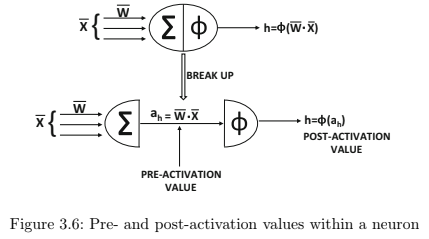

In the aforementioned discussion, the values $h_1, \dots, h_k$ along a path are used to compute the
chain rule. However, one can also use the values before computing the activation function in order to define the chain rule. In other words, the gradients are computed with respect to the pre-activation values of the hidden variables, which are then propagated backwards. This alternative approach to backpropagation is how it is presented in most textbooks.

Pre-activation value of the hidden variable $h_r$ is denoted by $a_{h_r}$ where:

$$h_r = \Phi (a_{h_r}) \qquad (3.14)$$

$$\frac{\partial L}{\partial w_{(h_{r-1}, h_r)}} = \frac{\partial L}{\partial o} \cdot \Phi '(a_o) \cdot
\left[\sum_{[h_r, \dots, h_k, o] \in \mathcal{P}} \frac{\partial a_o}{\partial a_{h_k}} 
\prod_{i=r}^{k-1} \frac{\partial a_{h_{i+1}}}{\partial a_{h_i}}\right] h_{r-1} \qquad (3.15)$$

where backpropagation computes $\delta(h_r, o) = \frac{\partial L}{\partial a_{h_r}}$, and $\delta ()$ symbolizes the enabling of recurrence. Note that it uses the hidden values **before** activation.

The other steps are relatively the same here as above, see page 116 for the additional equations and algorithm.


The main difference of this (more common) variant of the backpropagation algorithm is in terms of the way in which the recursion is written, because pre-activation variables have been used for dynamic programming. Both the pre- and post-activation variants of backpropagation are mathematically equivalent. We have chosen to show
both variations of backpropagation in order to emphasize the fact that one can use dynamic programming in a variety of ways to derive equivalent equations.